# NiCo Tutorial

## 1. Environment Prep

### 1.1. Modules

In [1]:
import os
from joblib import Memory
import scanpy as sc

from nico import Annotations as ann
from nico import Interactions as int
from nico import Covariations as cov

memory = Memory("./NiCo/cache", verbose=0)

### 1.2. Environment Variables

In [2]:
%%bash 
# in this exercise we need to modify the data so we copy a writeable version into the wd 
cp -r ../../datasets/Hands_on_3_NiCo/* . 

In [3]:
query_datapath = "./NiCo/inputQuery/"
ref_datapath = "./NiCo/inputRef/"
output_nico_dir = "./NiCo/nico_out/"
lrdb_filename = "./NiCo/NiCoLRdb.txt"

ref_cluster_tag = "cluster"  # scRNAseq cell type slot
annotation_slot = "nico_ct"  # spatial cell type slot

## 2. Preprocessing

Results in the following folder structure:

```text
data/inputQuery
├── mouse_intestine_spatial.h5ad -> the original spatial input data
└── sct_spatial.h5ad -> the transformed and subset spatial
data/inputRef
├── mouse_intestine_sc.h5ad -> the original single cell input data
├── Original_counts.h5ad -> the raw counts of the single cell data
└── sct_singleCell.h5ad -> the transformed single cell data
```

### 2.1. Load and Filter Data

In [4]:
adata_query = sc.read_h5ad(query_datapath + "mouse_intestine_spatial.h5ad")
adata_reference = sc.read_h5ad(ref_datapath + "mouse_intestine_sc.h5ad")

sc.pp.filter_cells(adata_query, min_counts=5)
sc.pp.filter_cells(adata_reference, min_counts=5)

sc.pp.filter_genes(adata_query, min_cells=1)
sc.pp.filter_genes(adata_reference, min_cells=1)

### 2.2. Save raw reference counts

In [5]:
@memory.cache
def save_reference(adata):
    Original_counts = adata.copy()
    Original_counts.raw = Original_counts.copy()
    sc.pp.normalize_total(Original_counts)
    sc.pp.log1p(Original_counts)
    sc.tl.pca(Original_counts)
    sc.pp.neighbors(Original_counts)
    #sc.tl.umap(Original_counts)
    return Original_counts

Original_counts = save_reference(adata_reference)
Original_counts.write_h5ad(ref_datapath + "Original_counts.h5ad")

### 2.3. Perform scTransform on shared gene space

In [6]:
index_sp, index_sc = ann.find_index(
    adata_query.var_names.to_numpy(), adata_reference.var_names.to_numpy()
)

ad_seq_common = adata_reference.copy()
ad_spatial_common = adata_query[:, index_sp].copy()

temp_spatial = ad_spatial_common.copy()
temp_seq = ad_seq_common.copy()

In [7]:
ad_spatial_common = memory.cache(ann.SCTransform)(
    ad_spatial_common,
    min_cells=1,
    gmean_eps=1,
    n_genes=500,
    n_cells=None,
    bin_size=500,
    bw_adjust=3,
    inplace=False,
)

ad_seq_common = memory.cache(ann.SCTransform)(
    ad_seq_common,
    min_cells=1,
    gmean_eps=1,
    n_genes=500,
    n_cells=None,
    bin_size=500,
    bw_adjust=3,
    inplace=False,
)

In [8]:
ad_spatial_common.raw = temp_spatial.copy()
ad_spatial_common.obsm["spatial"] = temp_spatial.obsm["spatial"]
ad_seq_common.raw = temp_seq.copy()

ad_seq_common.write_h5ad("./NiCo/inputRef/sct_singleCell.h5ad")

### 2.4. Perform Leiden clustering to guide label transfer

The number of clusters should reflect the number of celltypes in the reference we expect to find in the spatial data. It might take some adapation of the Leiden resolution parameter to find a good clustering.

In [9]:
@memory.cache
def perform_guiding_clustering(adata, n_pcs: int = 30, leiden_res: float = 0.4):
    adata_copy = adata.copy()
    sc.pp.pca(adata_copy)
    sc.pp.neighbors(adata_copy, n_pcs=n_pcs)
    sc.tl.umap(adata_copy)
    key_added = f"leiden{leiden_res}"
    sc.tl.leiden(adata_copy, resolution=leiden_res, key_added=f"leiden{leiden_res}")
    return adata_copy
    
leiden_res = 0.4
ad_spatial_common = perform_guiding_clustering(ad_spatial_common, leiden_res=leiden_res)

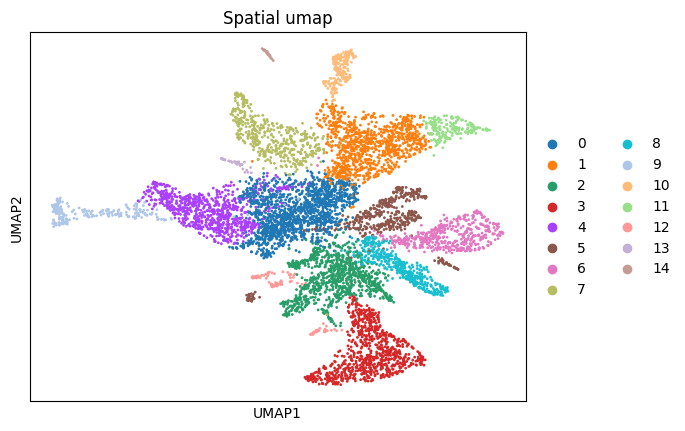

In [10]:
key_added = f"leiden{leiden_res}"
sc.pl.umap(
    ad_spatial_common,
    color=[key_added],
    title=["Spatial umap"],
    wspace=0.4,
    show=True,
    save="_spatial_umap.png",
)

In [11]:
ad_spatial_common.write_h5ad(query_datapath + "sct_spatial.h5ad")

## 3. Label Transfer

### 3.1. Computation

1. Principal components are computed based on the (transformed) single cell reference.
2. The (transformed) cells from the spatial dataset are projected into this latent space and based on an Euclidian distance metric cells are identified that 'anchor' the spatial data with the single cell reference.
3. Labels are propagated iteratively from the anchor cells to neighbouring cells in the latent space, with guidance from the Leiden clustering.
4. Annotation saved

In [12]:
anchors_and_neighbors_info = memory.cache(ann.find_anchor_cells_between_ref_and_query)(
    refpath=ref_datapath,
    quepath=query_datapath,
    output_nico_dir=output_nico_dir,
)

In [13]:
output_info = memory.cache(ann.nico_based_annotation)(
    anchors_and_neighbors_info,
    guiding_spatial_cluster_resolution_tag=key_added,
    ref_cluster_tag=ref_cluster_tag,
)

In [14]:
ann.save_annotations_in_spatial_object(output_info)

Nico cell type cluster are saved in following path './nico_out/' as <anndata>.obs['nico_ct'] slot


### 3.2. Visualization

#### 3.2.1. Full annotation

The figures are saved:  ./NiCo/nico_out/annotations/tissue_and_umap_with_all_celltype_annotations.pdf


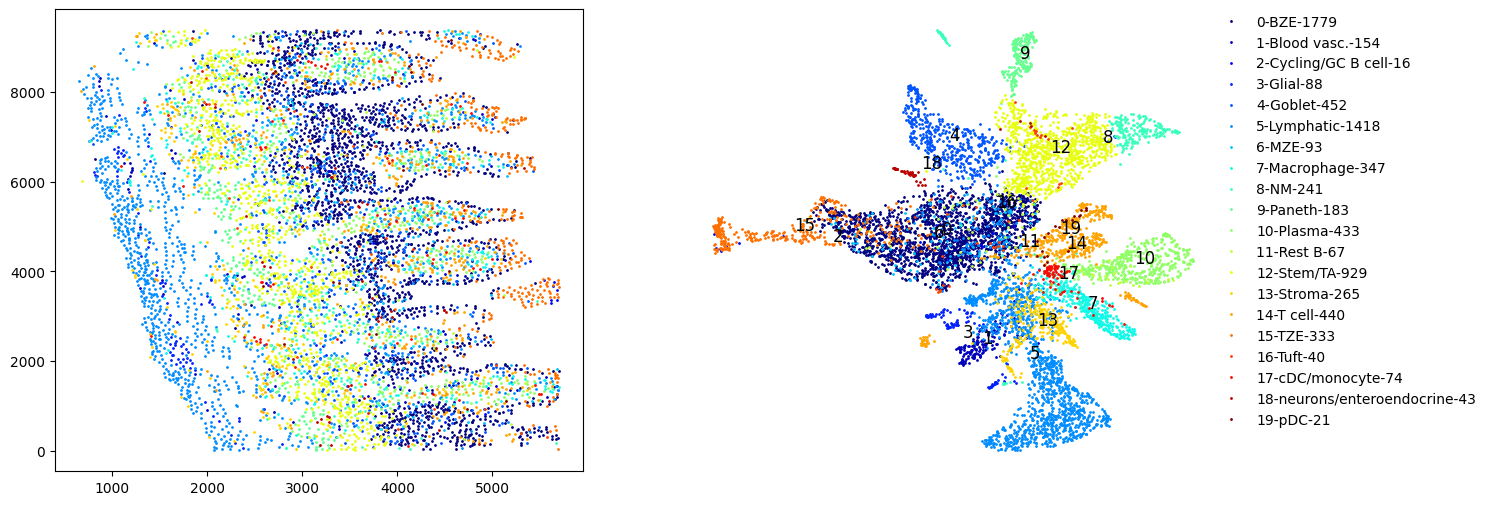

In [15]:
ann.visualize_umap_and_cell_coordinates_with_all_celltypes(
    output_nico_dir=output_nico_dir,
)

#### 3.2.2. Filtered for cells of interest

The figures are saved:  ./NiCo/nico_out/annotations/fig_individual_annotation/Stem_TA0.pdf
The figures are saved:  ./NiCo/nico_out/annotations/fig_individual_annotation/Paneth1.pdf


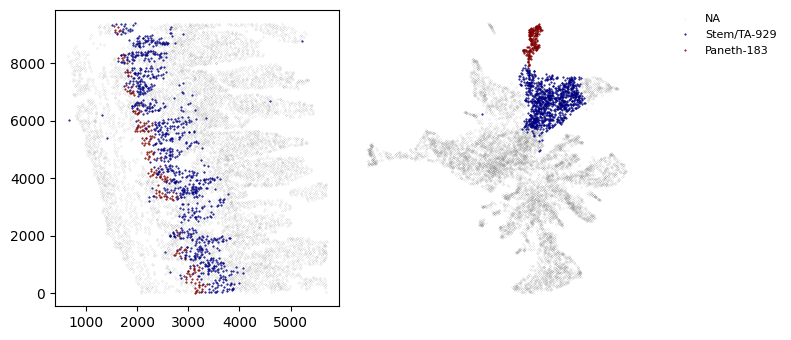

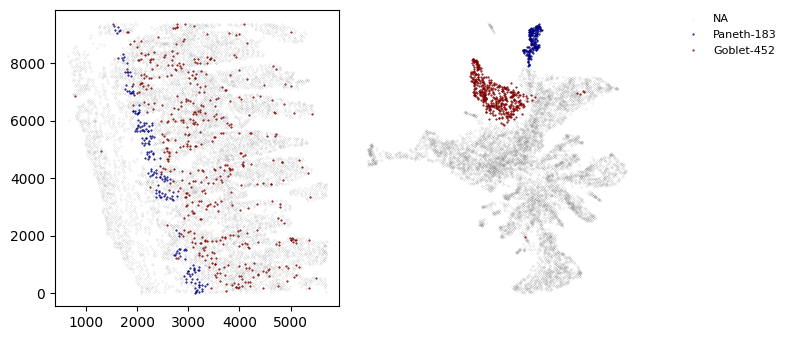

In [16]:
choose_celltypes = [["Stem/TA", "Paneth"], ["Paneth", "Goblet"]]

ann.visualize_umap_and_cell_coordinates_with_selected_celltypes(
    choose_celltypes=choose_celltypes,
    output_nico_dir=output_nico_dir,
)


## 4. Niche Interactions

### 4.1. Computation

1. Graph is computed based on the spatial coordinates and a given radius
2. Local neighbourhood composition for each central cell is computed
3. Interaction coefficients are estimated via logarithmic regression

In this example we exclude celltypes with a very low abundance from the analysis.

**Note on Radius Definition**

The radius parameter (R) in NiCo controls how spatial neighbourhoods are defined around each central cell.
- When R = 0, NiCo considers only the immediate neighbours of each cell as determined by Delaunay triangulation. This setting focuses on direct cell–cell communication within tissues.
- When R > 0, NiCo extends the neighbourhood to include all cells within a specified distance from the central cell. This can capture paracrine or diffusive signalling, where molecules act over finite spatial ranges.

In practice, we recommend starting with R = 0, since:
- Immediate neighbours usually capture the strongest covariation and interaction signals.
- Increasing R smooths or averages signals across a larger set of cells, which can dilute the signal of interest.

In [17]:
inputRadius = 0

niche_pred_output = memory.cache(int.spatial_neighborhood_analysis)(
    Radius=inputRadius,
    output_nico_dir=output_nico_dir,
    removed_CTs_before_finding_CT_CT_interactions=[
        "Basophils",
        "Cycling/GC B cell",
        "pDC",
    ],
)

### 4.2. Visualization

#### 4.2.1. Plot interaction graph

The figures are saved:  ./NiCo/nico_out/niche_prediction_linear/Niche_interactions_with_edge_weights_R0.pdf


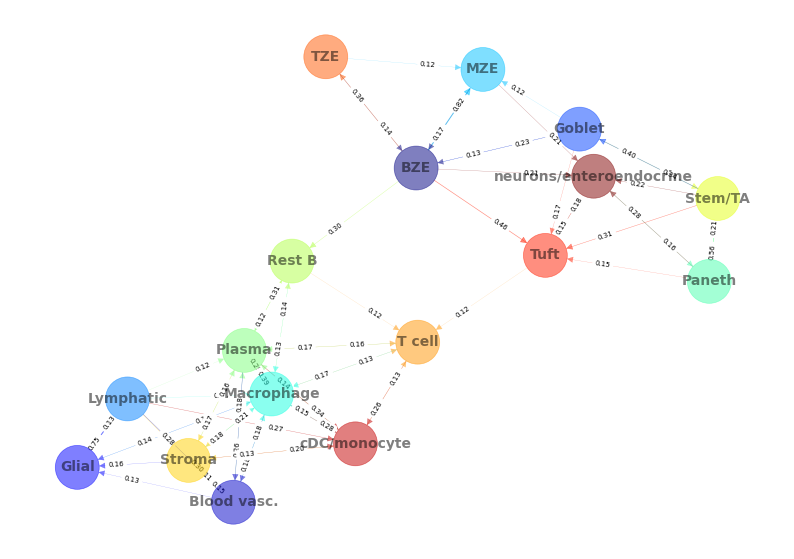

In [18]:
celltype_niche_interaction_cutoff = 0.1

int.plot_niche_interactions_with_edge_weight(
    niche_pred_output,
    niche_cutoff=celltype_niche_interaction_cutoff,
    node_size=1000,
    node_font_size=10,
    font_weight="bold",
    edge_font_size=5,
)

#### 4.2.2. Individual cell type niche plot
To plot regression coefficients of niche cell types for given central cell types, ordered by magnitude, <br>
add cell type names for the desired central cell types to the list argument choose_celltypes (e.g. Stem/TA <br>
and Paneth cells).

The figures are saved:  ./NiCo/nico_out/niche_prediction_linear/TopCoeff_R0/Rank2_Paneth.pdf
The figures are saved:  ./NiCo/nico_out/niche_prediction_linear/TopCoeff_R0/Rank3_Stem_TA.pdf


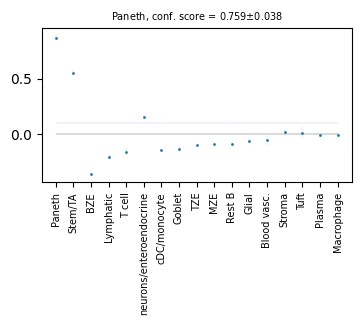

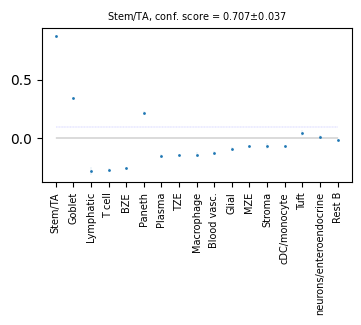

In [19]:
# Blue dotted line in following plot indicates the celltype_niche_interaction_cutoff

int.find_interacting_cell_types(
    niche_pred_output,
    choose_celltypes=["Stem/TA", "Paneth"],
    celltype_niche_interaction_cutoff=celltype_niche_interaction_cutoff,
)

## 5. Latent Feature Covariation Analysis

### 5.1. Computation

1. Latent spaces (default dimension = 3) are computed for each celltype via NMF, either with data integration or on single cell data only with projection of spatial data
2. Latent features are aggregated on the spatial neighbourhood graph and used to predict a neighbourhoods central cells latent features via Ridge regression.
The aggregation is optionally filtered as per the coefficients computed in the Interaction module, so that only positively interacting cell types are used.
3. Explainability of latent feature loadings is extended via correlation with the full gene set present in the reference data.
4. Ligand-Receptor analysis between two latent feature loadings is performed

<div style="
    background-color: #ffded1;
    border-left: 4px solid #ff0000;
    padding: 10px 15px;
    border-radius: 5px;
    margin: 10px 0;
">
<b>💡 Warning:</b> This computation takes a while so we are caching.
</div>


In [20]:
cov_out = memory.cache(cov.gene_covariation_analysis)(
    iNMFmode=True,  # Adjust in case of error prone segmentation
    Radius=inputRadius,
    refpath=ref_datapath,
    quepath=query_datapath,
    output_niche_prediction_dir=output_nico_dir,
    ref_cluster_tag=ref_cluster_tag,
    LRdbFilename=lrdb_filename,
)

### 5.2. Visualization

#### 5.2.1. Visualize the cosine similarity and Spearman correlation between genes and latent factors

The following function generates output for the top 30 genes based on cosine similarity (left) or Spearman correlation (right) with latent factors.

Select cell types by adding IDs to the list argument choose_celltypes, or leave empty for generating output for all cell types.

cell types found  ['Paneth']
The figures are saved:  ./NiCo/nico_out/covariations_R0_F3/NMF_output/Paneth.pdf


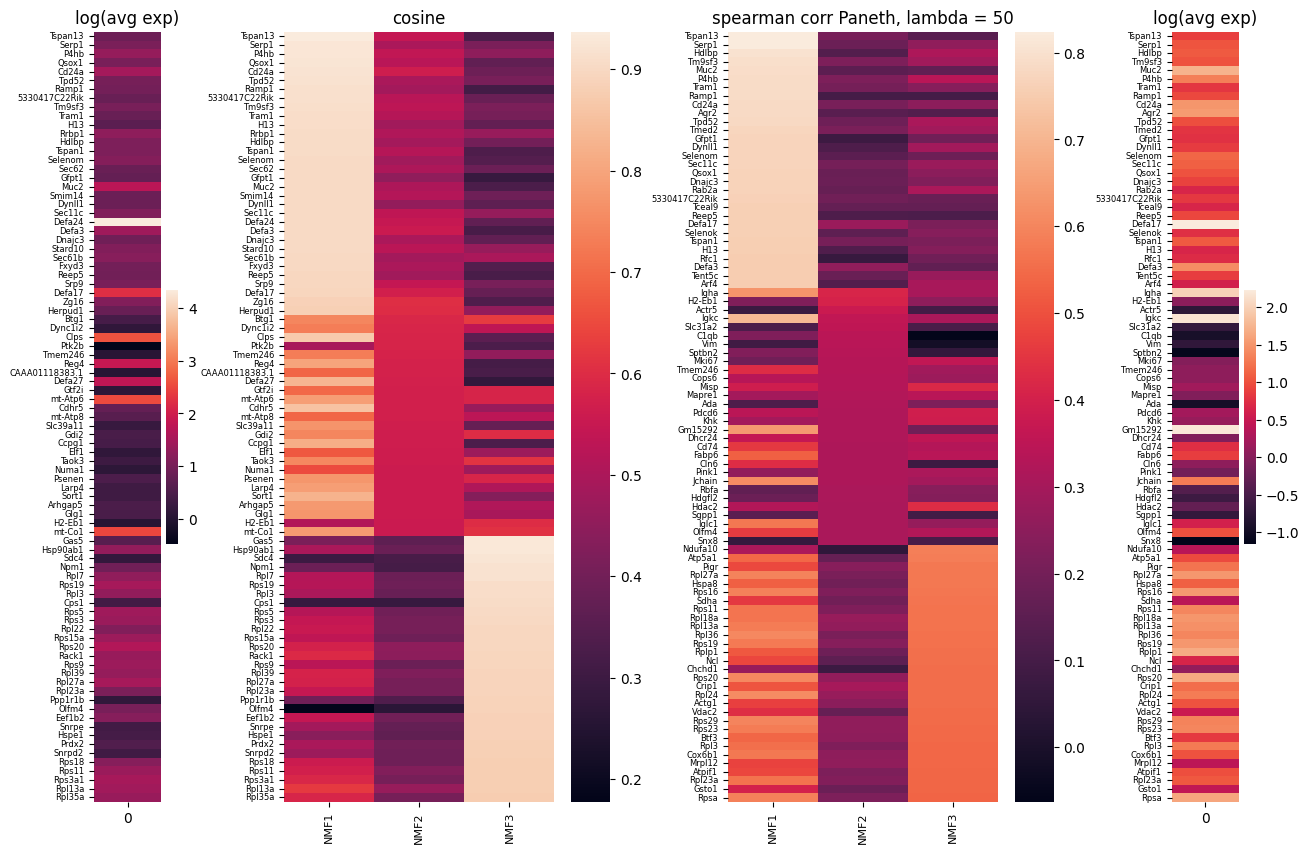

In [21]:
cov.plot_cosine_and_spearman_correlation_to_factors(
    cov_out,
    choose_celltypes=["Paneth"],
    figsize=(15, 10),
)

The figures are saved:  ./NiCo/nico_out/covariations_R0_F3/dotplots/Factors_Stem_TA.pdf


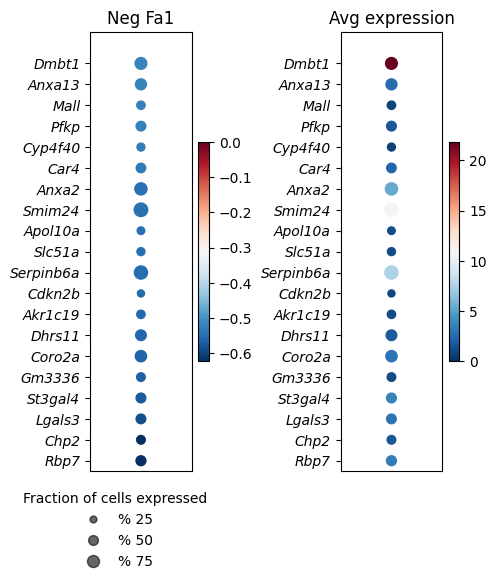

In [22]:
dataFrame = cov.extract_and_plot_top_genes_from_chosen_factor_in_celltype(
    cov_out,
    choose_celltype="Stem/TA",
    choose_factor_id=1,
    top_NOG=20,
    correlation_with_spearman=True,
    positively_correlated=False,
)

#### 5.2.2. Cell type covariation visualization

Plot linear regression coefficients between factors of the central cell type (y-axis, defined by list argument choose_celltypes) and factors of niche cell types (x-axis).

Circle size scales with -log10(p-value) (indicated as number on top of each circle). To generate plots for all cell types, leave list argument choose_celltypes empty.


cell types found  ['Stem/TA']
The regression figures as pvalue circle plots are saved in following path  ./NiCo/nico_out/covariations_R0_F3/Regression_outputs/pvalue_coeff_circleplot_*


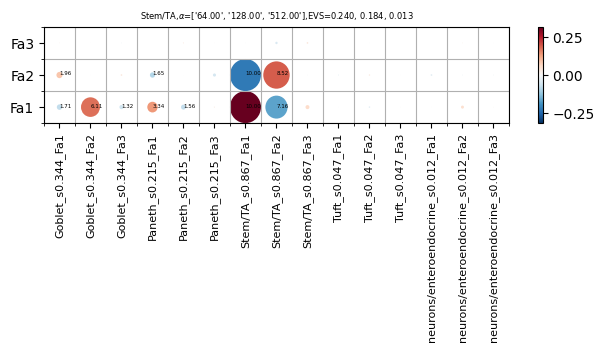

In [23]:
choose_celltypes = ["Stem/TA"]
cov.plot_significant_regression_covariations_as_circleplot(
    cov_out,
    choose_celltypes=choose_celltypes,
    mention_pvalue=True,
    figsize=(6, 1.25),
)


#### 5.2.3. Analysis of ligand-receptor interactions between covarying niche cell types

Perform ligand-receptors analysis. In this example, output is generated for the ligand-receptor pairs associated with the interacting factor 1 of Stem/TA cells and factor 1 of Paneth cells.

`choose_interacting_celltype_pair = ['Stem/TA', 'Paneth']`

`choose_factors_id = [1, 1]` entries correspond to cell types in `choose_interacting_celltype_pair`, i.e., first factor ID corresponds to `Stem/TA` and second factor ID corresponds to `Paneth`.

By default, the analysis is saved in 3 separate figures (bidirectional, CC to NC and NC to CC). CC: central cell, NC: niche cell.

Our analysis accounts for bidirectional cellular crosstalk interactions of ligands and receptors in cell types A and B. The ligand can be expressed on cell type A and signal to the receptor detected on cell type B, or vice versa.

By changing the cutoff for minimum factor correlation of ligand/receptor genes (`LR_plot_NMF_Fa_thres = 0.2`) or the cutoff for the minimum fraction of cells expressing the ligand/receptor genes (`LR_plot_Exp_thres = 0.2`), the stringency of the output filtering can be controlled.

LR figures for both ways are saved in following path  ./NiCo/nico_out/covariations_R0_F3/Plot_ligand_receptor_in_niche/
LR figures for CC to NC are saved in following path  ./NiCo/nico_out/covariations_R0_F3/Plot_ligand_receptor_in_niche_cc_vs_nc/
LR figures for NC to CC are saved in following path  ./NiCo/nico_out/covariations_R0_F3/Plot_ligand_receptor_in_niche_nc_vs_cc/


0

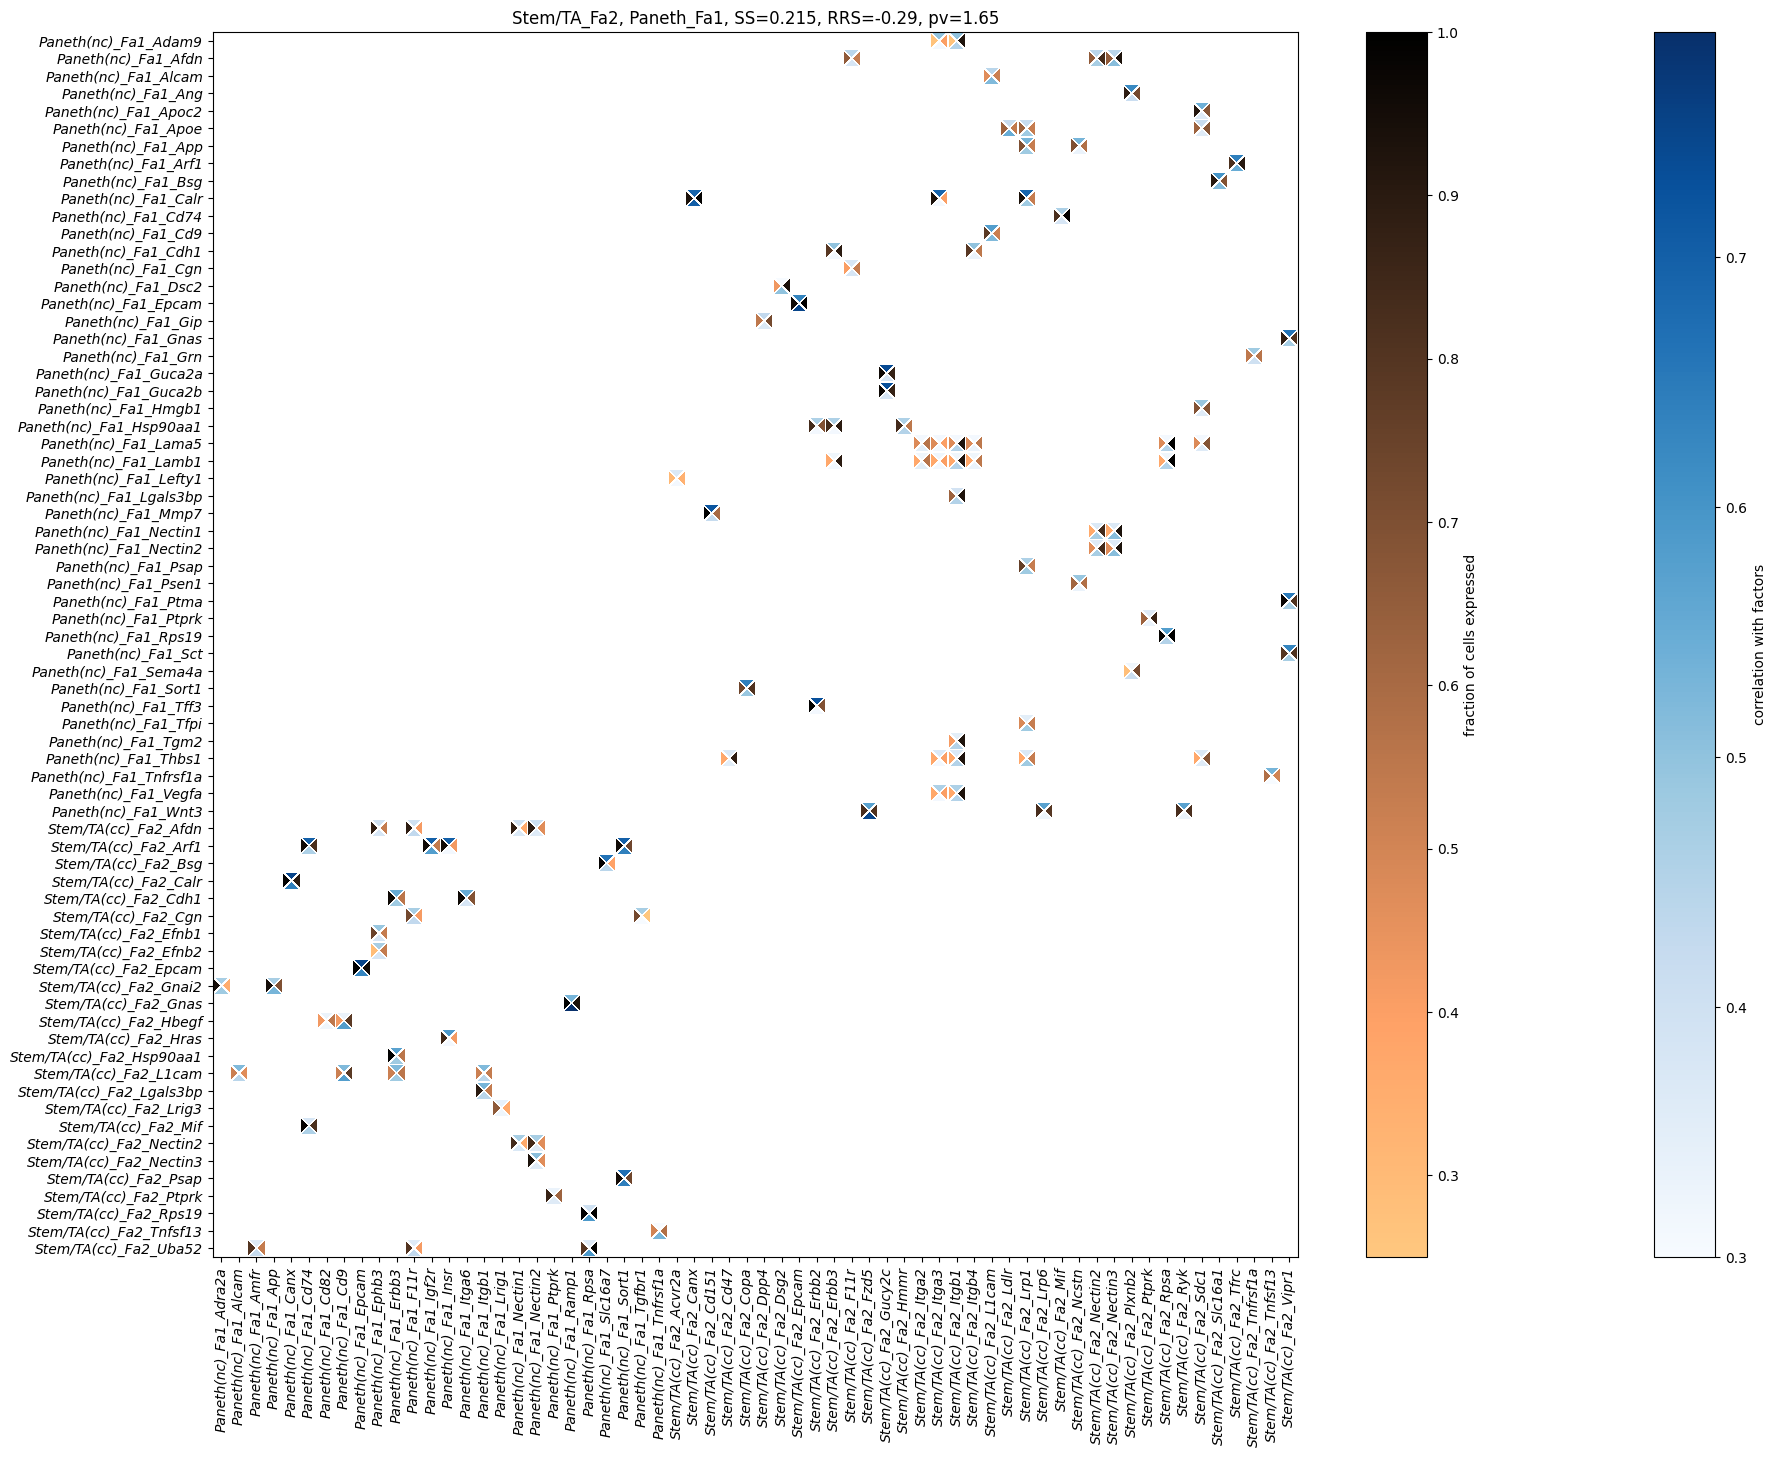

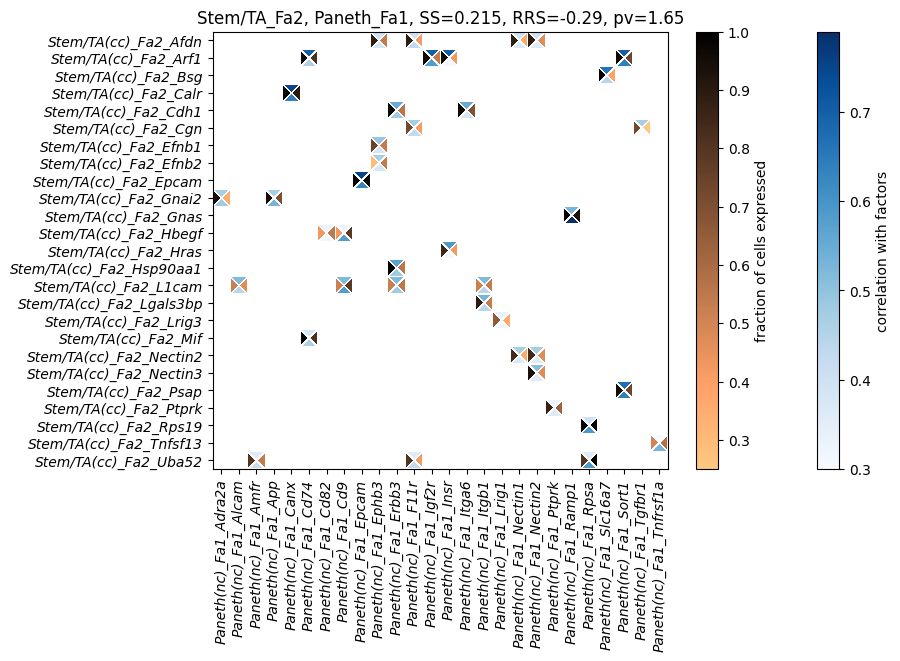

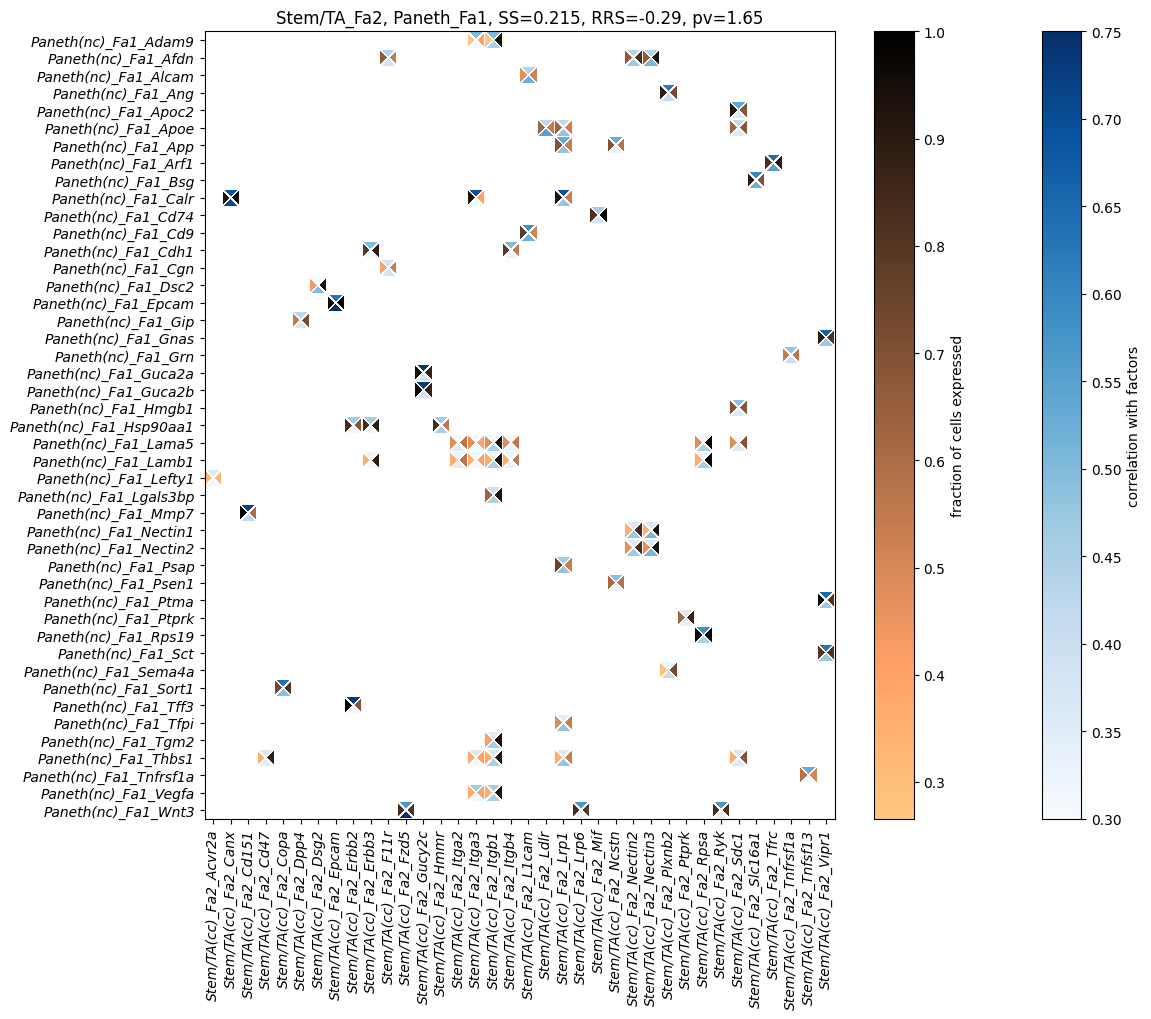

In [24]:
cov.find_LR_interactions_in_interacting_cell_types(
    cov_out,
    choose_interacting_celltype_pair=["Stem/TA", "Paneth"],
    choose_factors_id=[2, 1],
    pvalueCutoff=0.05,
    LR_plot_NMF_Fa_thres=0.3,
    LR_plot_Exp_thres=0.2,
    figsize=(12, 10),
    showit=True,
)

#### 5.2.4. Functional enrichment analysis for genes associated with latent factors

This step performs **pathway enrichment analysis** for genes most strongly associated with a selected latent factor.

In this example, enrichment is carried out for the **top 50** genes (`NOG_pathway=50`) that are **positively correlated** (`positively_correlated=True`) with **factor 2** (`choose_factors_id=[2]`) of **Stem/TA cells** (`choose_celltypes=['Stem/TA']`). The analysis tests for overrepresentation of **Gene Ontology (GO) Biological Processes** using the database specified by `database=['GO_Biological_Process_2021']`.

The pathway figures are saved in  ./NiCo/nico_out/covariations_R0_F3/Pathway_figures/
cell types found  ['Stem/TA']


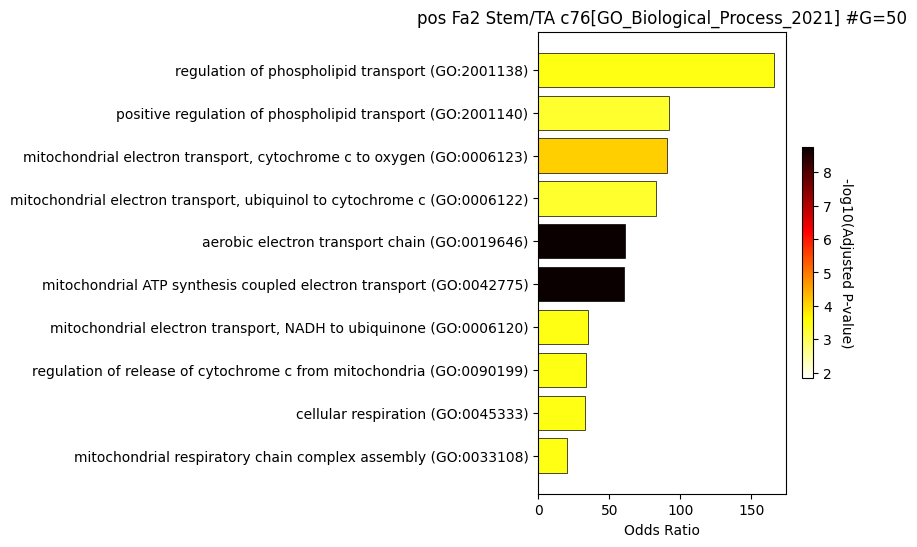

In [25]:
cov.pathway_analysis(
    cov_out,
    choose_celltypes=["Stem/TA"],
    NOG_pathway=50,
    choose_factors_id=[2],
    positively_correlated=True,
    database=["GO_Biological_Process_2021"],  # database=['BioPlanet_2019'],
    rps_rpl_mt_genes_included=False,
    display_plot_as="barplot",
    correlation_with_spearman=True,
    object_for_color="Adjusted P-value",
    object_for_xaxis="Odds Ratio",
    savefigure=False,
    input_colormap="hot_r",
)

#### 5.2.5. Visualization of top genes across cell types and factors as dotplot

Show the top 20 positively and negatively correlated genes (top_NOG=20) for all latent factors and the average expression of these genes on a log scale in a single plot. In this example, plots are generated for Paneth and Stem/TA cells.

If ```choose_celltypes=[]```, the plot will be generated for all cell
types.

cell types found  ['Paneth', 'Stem/TA']
The figures are saved:  ./NiCo/nico_out/covariations_R0_F3/dotplots/Paneth.pdf
The figures are saved:  ./NiCo/nico_out/covariations_R0_F3/dotplots/Stem_TA.pdf


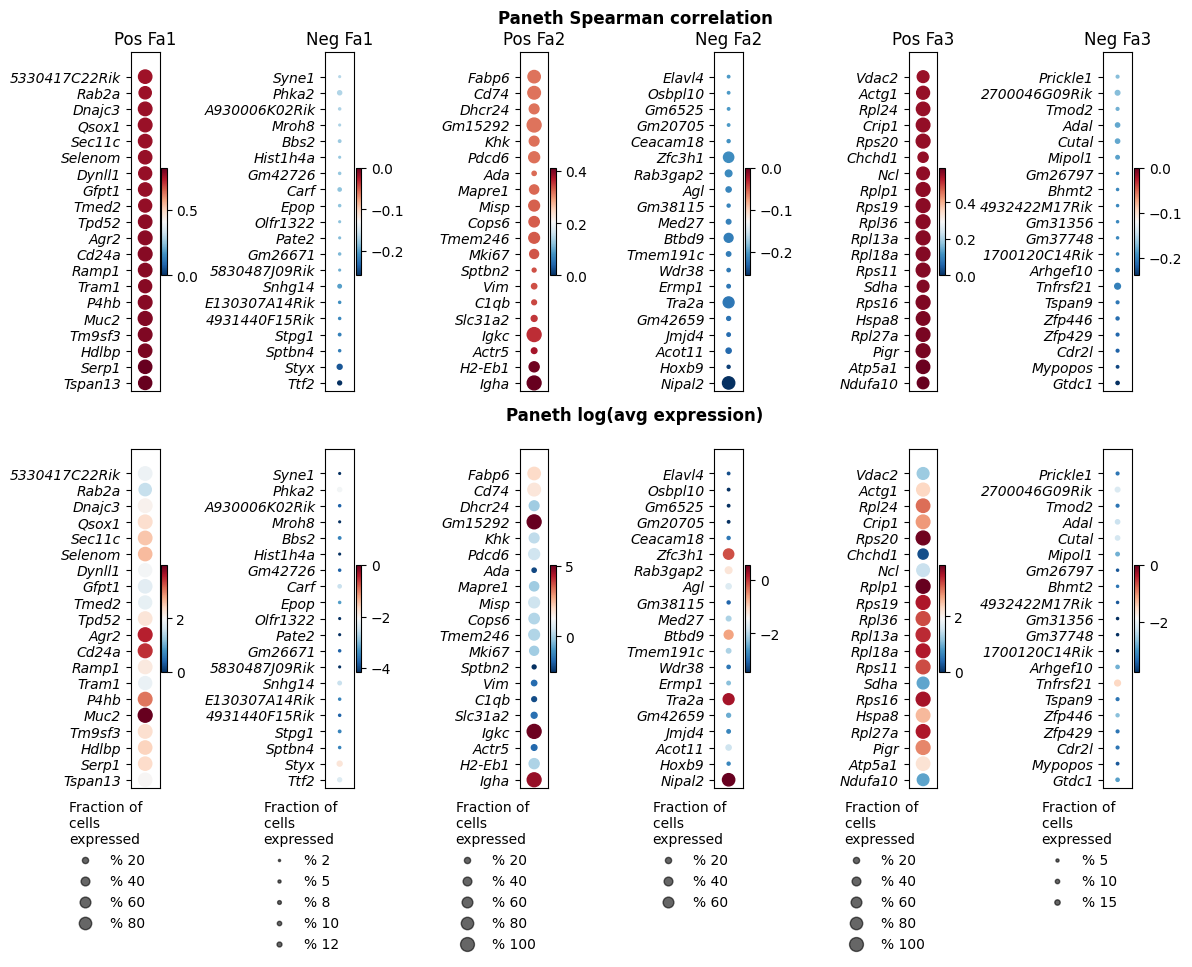

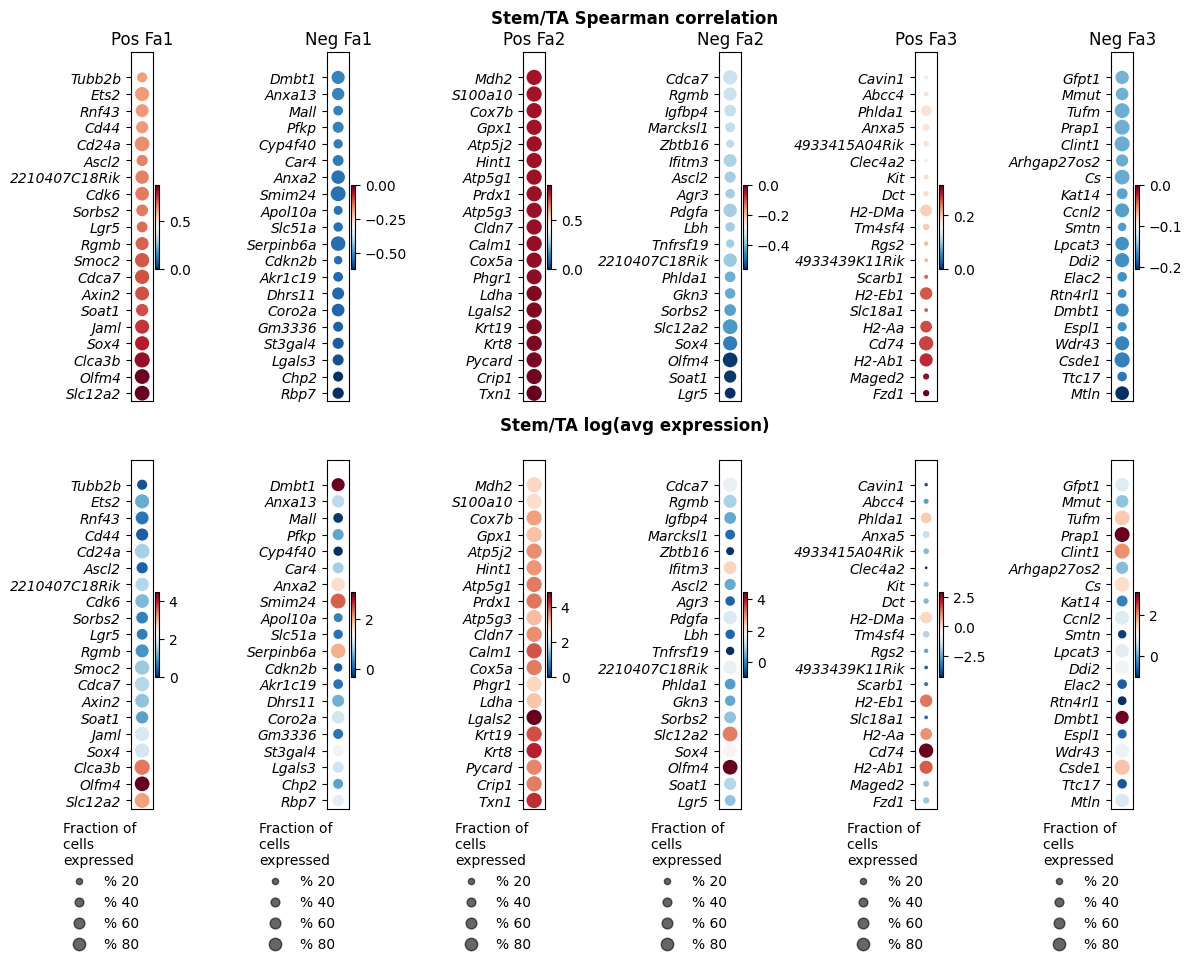

In [26]:
cov.plot_top_genes_for_a_given_celltype_from_all_factors(
    cov_out,
    choose_celltypes=["Paneth", "Stem/TA"],
    top_NOG=20,
)